## Imports

In [2]:
!pip install --upgrade tensorflow

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Step 1: Load data

In [14]:

with open('../DataInputs/Weekly/amazon_weekly_close.json', 'r') as file:
    data = json.load(file)

# Convert data to a sorted list of tuples (date, price)
sorted_data = sorted((pd.to_datetime(date), float(price)) for date, price in data.items())

# Separate dates and prices
dates, prices = zip(*sorted_data)


## Step 2: Preprocess data

In [15]:
# reshaping the array to 2D as required by the scaler
prices = np.array(prices).reshape(-1, 1)

# Normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


## Step 3: Split the data

In [16]:
# Split data into training and testing sets
train_data, test_data = train_test_split(scaled_prices, test_size=0.2, shuffle=False)


## Step 4: Prepare data for LSTM

In [17]:
# Create training and testing datasets
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)


In [18]:

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [19]:

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Step 5: Build the LSTM model

In [20]:

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


## Step 6: Train the model

In [21]:

model.fit(X_train, y_train, batch_size=1, epochs=1)


907/907 [==============================] - 50s 48ms/step - loss: 6.2852e-04


In [22]:

# Prepare the initial state from the end of the training set
last_train_batch = train_data[-time_step:]
last_train_batch = last_train_batch.reshape((1, time_step, 1))


In [23]:

# Generate predictions on the test data
test_predictions = []

# Start at the beginning of the test_data and iterate over it to make predictions
for i in range(len(test_data) - time_step):
    # Reshape the input for the model to make a prediction
    current_batch = test_data[i:(i + time_step), 0]
    current_batch = current_batch.reshape((1, time_step, 1))
    
    # Get the prediction (only one at each step) and store it
    test_pred = model.predict(current_batch)[0]
    test_predictions.append(test_pred)


1/1 [==============================] - 0s 55ms/step


In [24]:

# Flatten the test_predictions list and scale back to original values
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate the starting index for plotting test predictions
test_start_index = len(train_data) + time_step

# Ensure that we have the same number of dates as test predictions for plotting
plot_dates = dates[test_start_index:test_start_index + len(test_predictions)]


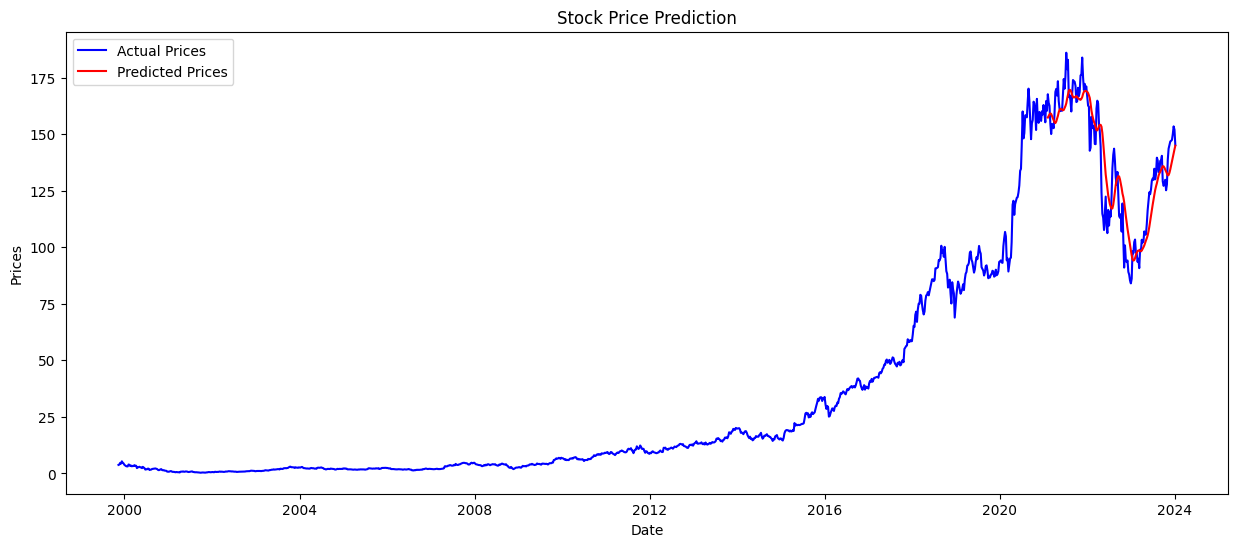

In [25]:

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(dates, prices, label='Actual Prices', color='blue')  # Plot all actual prices
plt.plot(plot_dates, test_predictions, label='Predicted Prices', color='red')  # Plot test predictions
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()



## RMSE & MAE

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Since we have already scaled the test data and predicted data, we need to inverse the scaling to get meaningful error metrics
actual_test_prices = scaler.inverse_transform(test_data[time_step:])
predicted_test_prices = test_predictions

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_test_prices, predicted_test_prices))
mae = mean_absolute_error(actual_test_prices, predicted_test_prices)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')


Test RMSE: 11.56890786391549
Test MAE: 9.075679583381204


## Evaluating on specific dates

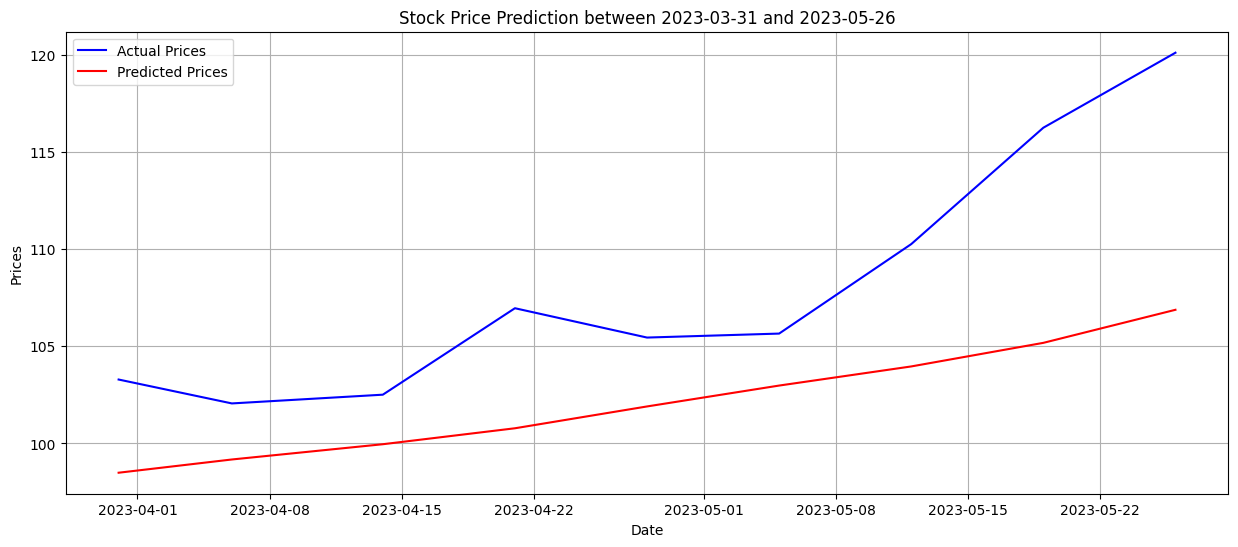

In [28]:
# Convert dates to a list
dates = list(dates)
#print(dates)
#print(dates[1220])
# Define the start and end dates
start_date = pd.to_datetime('2023-03-31 00:00:00')
end_date = pd.to_datetime('2023-05-26 00:00:00')

# Find the indices corresponding to the start and end dates
start_index = dates.index(start_date)
end_index = dates.index(end_date)

# Extract the selected dates and prices
selected_dates = dates[start_index:end_index+1]
selected_prices = prices[start_index:end_index+1]
selected_predictions = test_predictions[start_index-test_start_index:end_index-test_start_index+1]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(selected_dates, selected_prices, label='Actual Prices', color='blue')
plt.plot(selected_dates, selected_predictions, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction between 2023-03-31 and 2023-05-26')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure that both arrays are of the same shape
selected_prices = np.array(selected_prices).reshape(-1, 1)
selected_predictions = np.array(selected_predictions).reshape(-1, 1)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(selected_prices, selected_predictions))
mae = mean_absolute_error(selected_prices, selected_predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 6.936474498042862
MAE: 5.914512837727866
